# 🏔 Monte Carlo Every Visit

**Monte Carlo Every-Visit** é um algoritmo de controle por Monte Carlo, ou seja, ele estima nossa função de valor *q(s, a)* a partir dos retornos médios de cada par estado-ação, e toma ações no ambiente com base nessas estimativas. 

Entretanto, esse algoritmo difere de outros métodos de Monte Carlo por utilizar todos os retornos de um par estado-ação durante um episódio. Isso significa que, quando o nosso agente visita um estado repetido e toma uma mesma ação, o cálculo da função de valor levará em conta o retorno de todas as vezes que essa ação foi tomada.

## Política ε-greedy

Para garantir que os métodos de Monte Carlo convirjam para a função de valor real, é necessário seguir uma política que explore todas as ações de todos os estados. Entretanto, também é interessante que o agente tente conseguir cada vez mais recompensas, para maximizar sua perfomance.

Assim foi desenvolvida a política *ε-greedy*, que escolhe a próxima ação com base em um parâmetro *ε*, normalmente pequeno. A cada decisão, a política tem uma probabilidade *ε* de escolher uma ação aleatória, aumentando a exploração, e uma probabilidade *1 - ε* de escolher a ação associada ao maior *Q*. Dessa forma, ela estabelece um equilíbrio entre a exploração de ações e a explotação de recompensas. Essa política é dada por:

<img src="https://latex.codecogs.com/svg.latex?\pi(a|S_t)&space;\leftarrow&space;\begin{cases}&space;1&space;-&space;\varepsilon&space;&plus;&space;\varepsilon/\left|\mathcal{A}(S_t)\right|,&space;&&space;\mbox{se&space;}&space;a&space;=&space;\underset{a}{\mathrm{argmax}}&space;\,&space;Q(S_t,a)&space;\\&space;\varepsilon/\left|\mathcal{A}(S_t)\right|,&space;&&space;\mbox{se&space;}&space;a&space;\neq&space;\underset{a}{\mathrm{argmax}}&space;\,&space;Q(S_t,a)&space;\end{cases}" title="\pi(a|S_t) \leftarrow \begin{cases} 1 - \varepsilon + \varepsilon/\left|\mathcal{A}(S_t)\right|, & \mbox{se } a = \underset{a}{\mathrm{argmax}} \, Q(S_t,a) \\ \varepsilon/\left|\mathcal{A}(S_t)\right|, & \mbox{se } a \neq \underset{a}{\mathrm{argmax}} \, Q(S_t,a) \end{cases}" />

<img src="https://latex.codecogs.com/svg.latex?\left|\mathcal{A}(S_t)\right|&space;\rightarrow&space;\textrm{quantidade&space;de&space;acoes&space;possiveis}" title="\left|\mathcal{A}(S_t)\right| \rightarrow \textrm{quantidade de acoes possiveis}" />

## Algoritmo

Primeiramente, devemos inicializar a nossa tabela *Q(s, a)* com valores arbitrários para cada par estado-ação. Nesse caso, vamos optar por superestimar os valores Q de modo a incentivar a exploração do agente.

Também inicializamos uma tabela *N(s, a)* que guarda a quantidade de retornos obtidos de cada par estado-ação, para fazer o cálculo da média móvel dos retornos.

Para cada episódio, vamos escolher ações seguindo nossa política ε-greedy e guardar os estados, ações e recompensas para cada instante *t*. Ao final, calculamos o retorno *G* de cada instante começando pelo término atualizando os valores *Q* correspondentes.

Para estimar a média dos retornos, podemos utilizar a *média móvel*, de forma a realizar os cálculos na hora sem precisar guardar uma lista com todos os retornos. Ao invés disso, precisamos guardar apenas a média anterior e a quantidade total de elementos *n*.

<img src="https://latex.codecogs.com/svg.latex?{\overline&space;{x}}_{novo}&space;=&space;\frac{(n&space;-&space;1){\overline&space;{x}}_{anterior}&space;&plus;&space;x_n}{n}" title="{\overline {x}}_{novo} = \frac{(n - 1){\overline {x}}_{anterior} + x_n}{n}" />

Por fim, podemos ver abaixo um exemplo em pseudo-código do funcionamento do algoritmo de Monte Carlo Every-Visit:

![On-policy every-visit MC control](imgs/MC.svg)

## Código

Antes de começar a programar nosso algoritmo, devemos importar a biblioteca ***gym*** e criar o ambiente *FrozenLake-v0*, que usaremos para testar o Monte Carlo Every-Visit.

In [1]:
# Importando a biblioteca gym
import gym

# Criando o ambiente
env = gym.make("FrozenLake-v0")
env.seed(42)

[42]

Em seguida, vamos definir uma função argmax, que retornará o índice do elemento de maior valor dentro de um vetor. Usaremos essa função para escolher a ação com maior valor *Q* dentro da nossa tabela de valores.

É importante definir nossa própria função de argmax pois, em casos de empate, ela deve decidir aleatoriamente entre um dos índices dos elementos de maior valor.

In [2]:
def argmax(array):
    """Retorna o argumento máximo de uma lista."""
    return np.random.choice(np.flatnonzero(array == array.max()))

### Agente

Agora sim podemos criar o nosso agente, uma classe com os métodos *step*, *store_experience* e *update*:
  - `step(self, state, epsilon=0)` - Escolhe a próxima ação a se tomar com base no estado atual.
  
  - `store_experience(self, state, action, reward)` - Guarda a tupla (*estado*, *ação, *recompensa*) atual, para depois realizar o cálculo dos retornos.
  
  - `update(self)` - Atualiza a função valor com base nos retornos do episódio.

In [3]:
import numpy as np
from collections import defaultdict

class MonteCarloAgent(object):
    """Agente de Monte Carlo."""
    def __init__(self, gamma, action_space):
        """Inicializa o agente.

        Parâmetros
        ----------
        gamma: float
            Fator de desconto.
        action_space: Space
            Espaço de ação do ambiente.
        """
        # Dicionário com as nossas estimativas de Q para cada par estado-ação
        self.q_values = defaultdict(lambda: np.ones(action_space.n))
        
        # Dicionário com a quantidade de vezes que visitamos cada par estado-ação
        self.times_visited = defaultdict(lambda: np.zeros(action_space.n))
        
        # Lista para guardar as transições de um episódio
        self.experiences = []
        self.gamma = gamma
        self.action_space = action_space
        
    def step(self, state, epsilon=0):
        """Escolhe uma ação.

        Parâmetros
        ----------
        state: np.array
            Estado no instante atual.
        epsilon: float
            Probabilidade de escolher uma ação aleatoriamente. (default 0)
            
        Retorna
        -------
        action: int
            Ação escolhida.
        """
        if np.random.random() < epsilon:
            action = self.action_space.sample()
        else:
            action = argmax(self.q_values[state])
        return action
    
    def store_experience(self, state, action, reward):
        """Guarda uma transição do episódio.

        Parâmetros
        ----------
        state: np.array
            Estado da transição.
        action: int
            Ação tomada.
        reward: float
            Recompensa recebida.
        """
        self.experiences.append((state, action, reward))
        
    def update(self):
        """Atualiza os valores q do agente."""
        g = 0
        for state, action, reward in reversed(self.experiences):
            g = self.gamma*g + reward
            self.times_visited[state][action] += 1
            self.q_values[state][action] = ((self.times_visited[state][action]-1) * self.q_values[state][action] + g)/self.times_visited[state][action]
            
        self.experiences = []

Agora que definimos o nosso agente, podemos instanciá-lo e treiná-lo.

In [17]:
# Instanciando nosso agente com um gamma igual a 0.9
agent = MonteCarloAgent(0.9, env.action_space)

### Treinamento

Para realizar o treinamento, vamos definir a seguinte função:

In [5]:
from collections import deque

def train(agent, env, episodes):
    """Treina um agente de Monte Carlo.

    Parâmetros
    ----------
    agent: MonteCarloAgent
        Agente de Monte Carlo.
    env: gym.Env
        Ambiente do Gym.
    episodes: int
        Quantidade de episódios para serem treinados.
    """
    # Guarda os retornos dos últimos episódios
    returns = deque(maxlen=1000)

    # Guarda uma média dos retornos
    mean_returns = []

    for episode in range(1, episodes+1):
        state = env.reset()
        done = False

        ep_return = 0

        while not done:
            # Escolhe uma ação com epsilon = 0.1
            action = agent.step(state, epsilon=0.1)

            # Toma a ação escolhida
            next_state, reward, done, _ = env.step(action)

            # Guarda a transição do estado
            agent.store_experience(state, action, reward)

            state = next_state
            ep_return += reward

        # Atualiza o agente ao final de cada episódio
        agent.update()

        returns.append(ep_return)

        mean_returns.append(np.mean(returns))

        # Mostra a taxa de sucesso do agente a cada 500 episódios
        if episode % 500 == 0:
            print(f"Episode: {episode:5d} Success Rate: {mean_returns[-1]:5.4f}\r", end="")
            
    return mean_returns

Em seguida, vamos treiná-lo em 50000 episódios:

In [18]:
mean_returns = train(agent, env, 50000)

Agora que nosso agente terminou de treinar, podemos testá-lo em 1000 episódios com epsilon = 0!

In [19]:
from collections import deque

# Guarda o retornos dos 1000 episódios
returns = deque(maxlen=1000)

for episode in range(1, 1001):
    state = env.reset()
    done = False
    
    ret = 0
    
    while not done:
        # Escolhe uma ação com epsilon = 0
        action = agent.step(state, epsilon=0)
        
        # Toma a ação escolhida
        next_state, reward, done, _ = env.step(action)
        
        state = next_state
        ret += reward
        
    returns.append(ret)

# Mostra a taxa de sucesso ao longo dos 1000 episódios
print(f"Success Rate: {np.mean(returns):5.4f}\r", end="")

Nosso agente conseguiu uma taxa de sucesso maior que 70%!

Como há muita aleatoriedade no ambiente, essa taxa de sucesso é uma das melhores possíveis.

#### Experimento com 20 treinamentos

Uma das grandes desvantagens dos métodos de Monte Carlo é sua alta variância. Logo, faz sentido analisar o desempenho do nosso algoritmo ao longo de vários treinamentos diferentes.

In [8]:
train_returns = []

for training in range(20):
    # Cria um novo agente
    agent = MonteCarloAgent(0.9, env.action_space)
    
    # Treina ele por 40000 episódios
    train_returns.append(train(agent, env, 40000))

#### Curva de Aprendizado

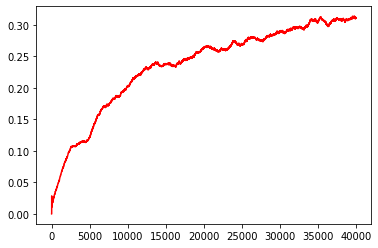

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.mean(train_returns, axis=0), 'r')
plt.show()